In [49]:
%config Completer.use_jedi = False

In [50]:
#hide
from fastai.vision.all import *
#from fastai.tabular.all import *
#from fastai.text.all import *
#from fastai.collab import *
from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display

FUNCS TO GET DATALOADERS AND MODEL

In [269]:
    
def get_dls(pth,resize=460,size=224,bs=8):
    dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
              get_items=get_image_files,
              get_y=parent_label,
              item_tfms=Resize(resize),
              batch_tfms=aug_transforms(size=size,
              min_scale=0.75)) 
    return dblock.dataloaders(pth, bs=bs,num_workers=0)  

def block(ni, nf): return ConvLayer(ni, nf, stride=2)

def get_body(data_ch):
    return nn.Sequential(
    block(data_ch, 16),
    block(16, 32),
    block(32, 64),
    block(64, 128),
    block(128, 256))
   

def get_head(body,n_out):
    # Pattern:[f(x) if condition else g(x) for x in sequence]
    ## Use np array+boolean indexing (why The EFF cant list be sliced as bools,anyhoo...) and taking the last convlayer
    last_conv_idx=np.array(range(len(body)))[np.array([type(layer)==ConvLayer for layer in body])][-1]
    last_conv_layer=body[last_conv_idx]
    n_in_head=last_conv_layer[0].out_channels
    return nn.Sequential(nn.AdaptiveAvgPool2d(1),Flatten(),nn.Linear(n_in_head, n_out))

## simple conv model
class ConvModel(nn.Module):
    def __init__(self,n_out,data_ch=3):
        super(ConvModel, self).__init__()
        self.body = get_body(data_ch)
        self.head = get_head(self.body,n_out)

    def forward(self, x):
        return self.head((self.body(x)))

## simple Hook to store layer outputs (activatons) to calc cmaps
class SaveCmapData_Hook():
    def __init__(self, learner,cmap_layer):
        self.cmap_hook = cmap_layer.register_forward_hook(self.hook_func_cmap)
        self.model_hook=learner.model.register_forward_hook(self.hook_func_model)
        self.data_in,self.data_out,self.data_cmap=[],[],[]
        
    def hook_func_cmap(self, m, i, o):
        self.data_cmap.append(o.detach().clone().cpu())
    def hook_func_model(self, m, i, o):
        self.data_in.append(i[0].detach().clone().cpu())
        self.data_out.append(o.detach().clone().cpu())
        
                                        
    def get_data(self):return (torch.cat(self.data_in),torch.cat(self.data_out),torch.cat(self.data_cmap))
    def __enter__(self, *args): return self
    def __exit__(self, *args): 
        self.cmap_hook.remove()
        self.model_hook.remove()                       
    
    
def Get_Preds_With_Cmaps(test_items,learner=conv_learner,cmap_layer=conv_learner.model.body):     
    with SaveCmapData_Hook(learner,cmap_layer) as h:
         PREDS=learner.get_preds(dl=learner.dls.test_dl(test_items))
    IPS,OPS,CMAPS=h.get_data()
    # assert (F.softmax(op,dim=1)==preds[0]) :output softmaxed it the predictionmop is the model op (till the last linear layer)
    # Calculating class activation maps by dot proding last conv layer o/p (before avg pooling: IMGS*bottleneckCHANNELS*H*W) and last linear layer
    CMAP_ACTS=learner.model.head[-1].cpu()(CMAPS.permute(0,2,3,1)).detach()
    return(test_items,IPS,OPS,PREDS,CMAP_ACTS)


def Show_Preds_With_Cmaps(pred_data,fig_cols=3,learner=conv_learner):
    
    test_items,IPS,OPS,PREDS,CMAP_ACTS=pred_data
    qfig_rows,rfig_cols=len(test_items)//fig_cols,len(test_items)%fig_cols
    _, axes_q = plt.subplots(qfig_rows,fig_cols,figsize=(6*fig_cols,6*qfig_rows), facecolor='w', edgecolor='k', constrained_layout=True,squeeze=False)
    
    if  rfig_cols==0:
        axes=axes_q.ravel()
    
    else:
        _,axes_r  =plt.subplots(1,rfig_cols,figsize=(4.5*rfig_cols, 4.5*1), facecolor='w', edgecolor='k', constrained_layout=True,squeeze=False)
        axes=np.concatenate((axes_q.ravel(),axes_r.ravel()))
    
    for ITEM,IP,OP,PRED,CMAP_ACT,ax in zip(test_items,IPS,OPS,PREDS[0],CMAP_ACTS,axes):
        # assert CMAP_ACT.mean(dim=(0,1))==OP
        pred_cls_idx,pred_cls_prob=PRED.argmax(),PRED.max()
        pred_cls=learner.dls.vocab[pred_cls_idx]
        ax.title.set_text("Predicted: "+pred_cls+" Confidence: "+str(pred_cls_prob.item()))
        ax.imshow(IP.permute(1,2,0))
        ax.imshow(CMAP_ACT[:,:,pred_cls_idx], alpha=0.4, extent=(0,img_H,img_W,0),
        interpolation='bilinear', cmap='magma')

    plt.show()
    
    
    


FUNCS TO TAKE USER INPUT THROUGH BUTTON  AND SAVE AS INTERNAL STATE

In [248]:
from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display

## all functions registered by buttons i.e used in button.on_click(func) must be a function of b <- func=f(b)
## this is to store state in attributes of b i.e b.something=F(User_Provided_Values)

def select_folder(b):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    ##b.folder=filedialog.askdirectory()
    b.folder=filedialog.askdirectory()
    # selected folder will be set button's folder attribute.
    #print(b.folder) # Print the list of files selected.
    

def select_file(b):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    b.file=filedialog.askopenfilename()

def select_files(b):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    b.files=L(filedialog.askopenfilenames())
  
def dls_from_folder(b):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    b.folder=filedialog.askdirectory()
    b.dls=get_dls(b.folder)
    

def run_prediction_with_cmap(b):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    b.pred_data=Get_Preds_With_Cmaps(L(filedialog.askopenfilenames()))
    Show_Preds_With_Cmaps(b.pred_data)
  
    


def get_button(description,on_click_fn):   
    button= Button(description=description)
    button.on_click(on_click_fn)
    return button
    



In [59]:
train_dl_button=get_button("select train folder",dls_from_folder)
valid_dl_button=get_button("select valid folder optional",dls_from_folder)
display(train_dl_button)
display(valid_dl_button)


Button(description='select train folder', style=ButtonStyle())

Button(description='select valid folder optional', style=ButtonStyle())

CHECK TRAINING DATA

120 image files detected


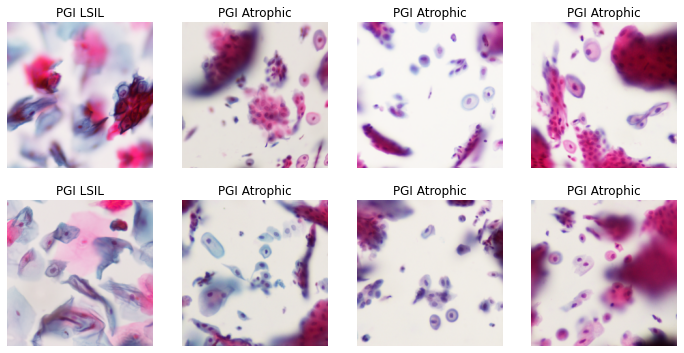

In [275]:
print(str(len(get_image_files(train_dl_button.folder)))+" image files detected")
train_dl_button.dls.show_batch()

CREATE LEARNER

In [276]:
conv_learner = Learner(dls=train_dl_button.dls,model=ConvModel(n_out=train_dl_button.dls.c),
loss_func=CrossEntropyLossFlat(), metrics=accuracy)

FIND A SUITABLE LEARNING RATE

SuggestedLRs(valley=tensor(0.0012))

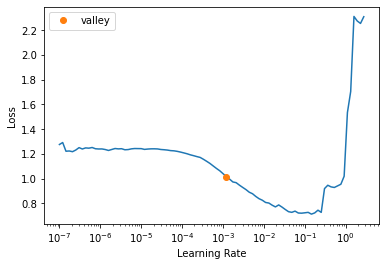

In [277]:
conv_learner.lr_find()

AND TRAIN  FOR A NUMBER OF EPOCHS,CBs optional

In [278]:
conv_learner.fit_one_cycle(7,0.0012,cbs=[EarlyStoppingCallback(monitor='valid_loss',min_delta=0.001,patience=3),
                                   SaveModelCallback(monitor='accuracy',min_delta=0.001)])
                                  

epoch,train_loss,valid_loss,accuracy,time
0,1.047126,1.132230,0.375000,00:05
1,0.677221,0.291895,0.875000,00:04
2,0.492256,0.073387,0.958333,00:04
3,0.388261,0.032673,1.000000,00:04
4,0.317285,0.156123,0.958333,00:04
5,0.248492,0.026407,1.000000,00:04
6,0.215789,0.014465,1.000000,00:04


Better model found at epoch 0 with accuracy value: 0.375.
Better model found at epoch 1 with accuracy value: 0.875.
Better model found at epoch 2 with accuracy value: 0.9583333134651184.
Better model found at epoch 3 with accuracy value: 1.0.


USE TRAINED MODEL FOR INFERENCE ON TEST ITEMS

In [274]:
Files_Selector_Button=get_button("select test files to Predict on",run_prediction_with_cmap)
display(Files_Selector_Button)

Button(description='select test files to Predict on', style=ButtonStyle())

FOR INFERENCE,CREATE TEST DL FROM TEST ITEMS - (FILENAMES/PILIMAGES etc.) like so: (Do not use dblock.dataloaders as it will redundantly call get_y). PS ITEMS has to be passed as a list [] remenber

A SIMPLE SMAP HOOK CLASS TO EXTRACT AVG POOLING LAYER ACTIVATIONS,TO USE TO COMPUTE CLASS ACTIVATION MAPS

In [104]:
class SaveCmapData_Hook():
    def __init__(self, learner,cmap_layer):
        self.cmap_hook = cmap_layer.register_forward_hook(self.hook_func_cmap)
        self.model_hook=learner.model.register_forward_hook(self.hook_func_model)
        self.data_in,self.data_out,self.data_cmap=[],[],[]
        
    def hook_func_cmap(self, m, i, o):
        self.data_cmap.append(o.detach().clone().cpu())
    def hook_func_model(self, m, i, o):
        self.data_in.append(i[0].detach().clone().cpu())
        self.data_out.append(o.detach().clone().cpu())
        
                                        
    def get_data(self):return (torch.cat(self.data_in),torch.cat(self.data_out),torch.cat(self.data_cmap))
    def __enter__(self, *args): return self
    def __exit__(self, *args): 
        self.cmap_hook.remove()
        self.model_hook.remove()                       

A SIMPLE SMAP HOOK CLASS TO EXTRACT FINAL LINEAR LAYER INPUTS AS THE MODEL TRAINS ,TO TEST FOR LINEAR SEPERABILITY BY DOING AN SVD ON Inputs

In [ ]:
class TrainVisualization_Hook():
    def __init__(self, learner):
        self.cmap_hook = cmap_layer.register_forward_hook(self.hook_func_cmap)
        self.model_hook=learner.model.register_forward_hook(self.hook_func_model)
        self.data_in,self.data_out,self.data_cmap=[],[],[]
        
    def hook_func_cmap(self, m, i, o):
        self.data_cmap.append(o.detach().clone().cpu())
    def hook_func_model(self, m, i, o):
        self.data_in.append(i[0].detach().clone().cpu())
        self.data_out.append(o.detach().clone().cpu())
        
                                        
    def get_data(self):return (torch.cat(self.data_in),torch.cat(self.data_out),torch.cat(self.data_cmap))
    def __enter__(self, *args): return self
    def __exit__(self, *args): 
        self.cmap_hook.remove()
        self.model_hook.remove()    

In [288]:
conv_learner

In [281]:
conv_learner.head[-1]

Linear(in_features=256, out_features=3, bias=True)

FOR INFERENCE,CREATE TEST DL FROM TEST ITEMS - (FILENAMES/PILIMAGES etc.) like so: (Do not use dblock.dataloaders as it will redundantly call get_y). PS ITEMS has to be passed as a list [] remenber  :Following function runs inference by creating a batch of test items

In [222]:
def Get_Preds_With_Cmaps(test_items,learner=conv_learner,cmap_layer=conv_learner.model.body):     
    with SaveCmapData_Hook(learner,cmap_layer) as h:
         PREDS=learner.get_preds(dl=learner.dls.test_dl(test_items))
    IPS,OPS,CMAPS=h.get_data()
    # assert (F.softmax(op,dim=1)==preds[0]) :output softmaxed it the predictionmop is the model op (till the last linear layer)
    # Calculating class activation maps by dot proding last conv layer o/p (before avg pooling: IMGS*bottleneckCHANNELS*H*W) and last linear layer
    CMAP_ACTS=learner.model.head[-1].cpu()(CMAPS.permute(0,2,3,1)).detach()
    return(test_items,IPS,OPS,PREDS,CMAP_ACTS)

In [268]:
def Show_Preds_With_Cmaps(pred_data,fig_cols=3,learner=conv_learner):
    
    test_items,IPS,OPS,PREDS,CMAP_ACTS=pred_data
    qfig_rows,rfig_cols=len(test_items)//fig_cols,len(test_items)%fig_cols
    _, axes_q = plt.subplots(qfig_rows,fig_cols,figsize=(6*fig_cols,6*qfig_rows), facecolor='w', edgecolor='k', constrained_layout=True,squeeze=False)
    
    if  rfig_cols==0:
        axes=axes_q.ravel()
    
    else:
        _,axes_r  =plt.subplots(1,rfig_cols,figsize=(4.5*rfig_cols, 4.5*1), facecolor='w', edgecolor='k', constrained_layout=True,squeeze=False)
        axes=np.concatenate((axes_q.ravel(),axes_r.ravel()))
    
    for ITEM,IP,OP,PRED,CMAP_ACT,ax in zip(test_items,IPS,OPS,PREDS[0],CMAP_ACTS,axes):
        # assert CMAP_ACT.mean(dim=(0,1))==OP
        pred_cls_idx,pred_cls_prob=PRED.argmax(),PRED.max()
        pred_cls=learner.dls.vocab[pred_cls_idx]
        ax.title.set_text("Predicted: "+pred_cls+" Confidence: "+str(pred_cls_prob.item()))
        ax.imshow(IP.permute(1,2,0))
        ax.imshow(CMAP_ACT[:,:,pred_cls_idx], alpha=0.4, extent=(0,img_H,img_W,0),
        interpolation='bilinear', cmap='magma')

    plt.show()
    
    
    